# Part 2 - Customer Segmentation and RFM Analysis with K-Means Clustering

by Hyder Ali

In here, we will continue the customer segmentation using Frequency and Monetary Value (Amount). The Frequency/Amount segmentation will create a sub-segment for each segment we already have (*Active, Warm, Cold, Inactive*). Creating sub-segments will group similar customers by how frequent they purchase and the average amount spent.

The Frequency/Amount segment is what will be used to send relevant promotions, based on how often a group of customers purchase and the average amount spent.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('data/Online Retail.xlsx', sheet_name = 'Online Retail')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
print("The data size is : ", data.shape)
print("There are %s customers" % len(set(data.CustomerID)))

The data size is :  (541909, 8)
There are 139452 customers


Segmenting customers by recency, frequency, and monetary value gives the E-Commerce business a way to prioritize customer outreach (based on recency) and personalized promotions (based on the average amount spent and how often customers purchase). We will be using year-2011 as the baseline year to identify the segment values for Frequency and Monetary variables.

In [4]:
# Using year 2011 as the baseline year to identify the segment values
data['InvoiceDateYear'] = data['InvoiceDate'].dt.year
data_2011 = data[data['InvoiceDateYear'] == 2011]

data_2011['MonetaryValue'] = abs(data_2011['UnitPrice'] * data_2011['Quantity'])

In [5]:
print("The data size is : ", data_2011.shape)
print("There are %s customers" % len(set(data_2011.CustomerID)))

The data size is :  (499428, 10)
There are 123693 customers


## K-Means Clustering on on Frequency and Monetary Value variables

Below we will prepare data for K-Means segmentation by Frequency (how often the customers purchase) and Monetary (average amount spent anually).

In [6]:
grouped_2011 = data_2011.groupby('CustomerID').aggregate({'InvoiceNo': pd.Series.nunique, 'MonetaryValue': 'mean'}).reset_index()
grouped_2011.rename({'InvoiceNo': 'FrequencyValue'}, axis = 'columns', inplace = True)

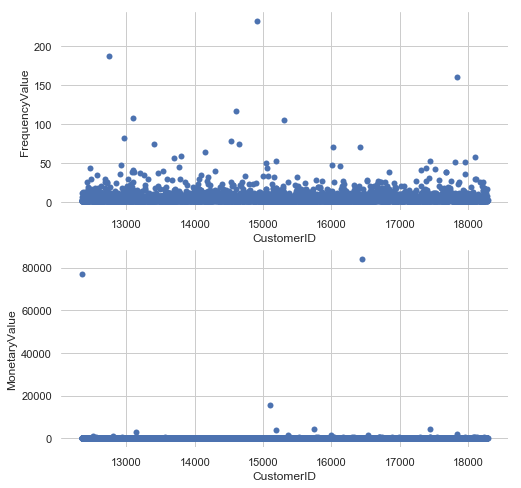

In [7]:
# Checking for Outliers
sns.set(style = "whitegrid")

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

sns.despine(f, left = True, bottom = True)
sns.scatterplot(x = 'CustomerID', y = 'FrequencyValue', palette="ch:r=-.2,d=.3_r", sizes=(1, 8), linewidth=0, data = grouped_2011, ax = ax1)
sns.scatterplot(x = 'CustomerID', y = 'MonetaryValue', palette="ch:r=-.2,d=.3_r", sizes=(1, 8), linewidth=0, data = grouped_2011, ax = ax2)

Based on the above plots, there are customers with severe outliers e.g. *Monetary Value (Average Amount Spent) > $10K*. As the goal is to capture the majority of customers in similar groups, we will remove these outliers because the K-means will likely create a segment with only 1 or two customers.

In [8]:
# Remove outliers
data_freq_mone_cluster = grouped_2011[(grouped_2011['MonetaryValue'] < 10000) & (grouped_2011['FrequencyValue'] < 50)]

print("After Outlier Removal:")
print("The data size for clustering is : ", data_freq_mone_cluster.shape)
print("There are %s customers" % len(set(data_freq_mone_cluster.CustomerID)))

After Outlier Removal:
The data size for clustering is :  (4220, 3)
There are 4220 customers


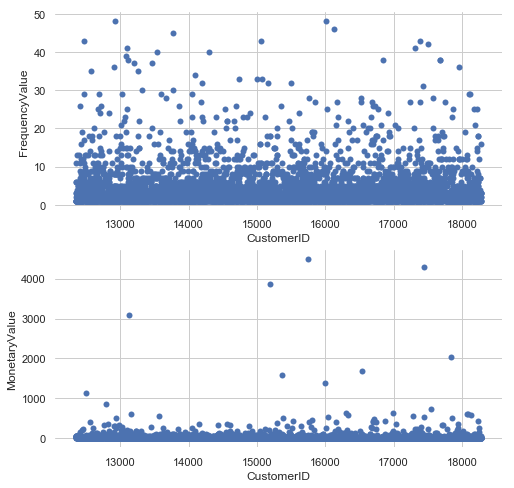

In [9]:
# After outlier removal
sns.set(style = "whitegrid")

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

sns.despine(f, left = True, bottom = True)
sns.scatterplot(x = 'CustomerID', y = 'FrequencyValue', palette="ch:r=-.2,d=.3_r", sizes=(1, 8), linewidth=0, data = data_freq_mone_cluster, ax = ax1)
sns.scatterplot(x = 'CustomerID', y = 'MonetaryValue', palette="ch:r=-.2,d=.3_r", sizes=(1, 8), linewidth=0, data = data_freq_mone_cluster, ax = ax2)

Next, will proceed to perform K-Means cluster  to determine the optimal number of clusters (segments). We will run the K-means algorithm with 1 to 15 clusters, then plot the outcome to determine the optimal number of clusters.

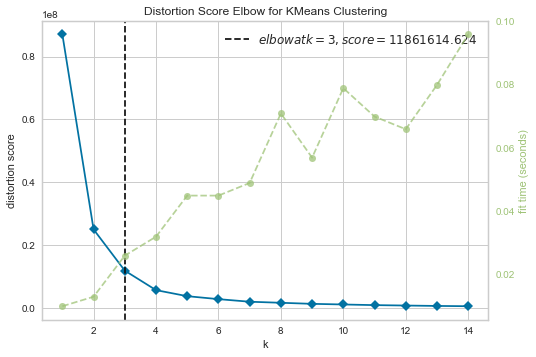

In [10]:
X_to_cluster = data_freq_mone_cluster[['FrequencyValue', 'MonetaryValue']] 

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15))

visualizer.fit(X_to_cluster)
visualizer.show()

The plots below shows each K-Means from 1 to 15 clusters. The midpoint of the bend(elbow) is then identified where the difference from point-to-point becomes less extreme at K = 3.

In [11]:
# K-Means using 3 clusters
k_means = KMeans(n_clusters = 3, init = 'k-means++')
k_means.fit(X_to_cluster)

data_freq_mone_cluster['FrequencyMonetarySegment'] = k_means.predict(X_to_cluster)
data_freq_mone_cluster['FrequencyMonetarySegment'].value_counts()

0    4166
2      50
1       4
Name: FrequencyMonetarySegment, dtype: int64

['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


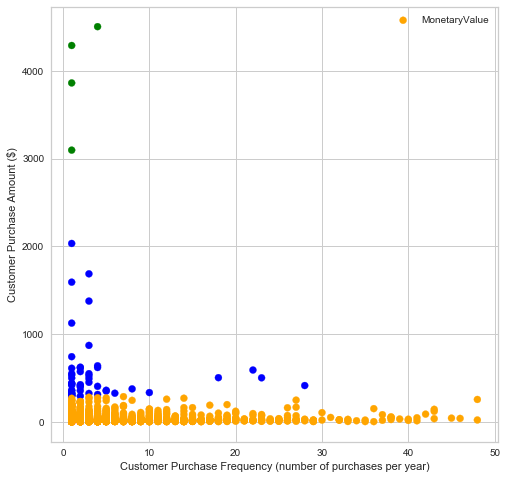

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
colors = ['orange','green','blue']
colored = [colors[k] for k in data_freq_mone_cluster['FrequencyMonetarySegment']]
print (colored[0:10])
plt.scatter(data_freq_mone_cluster['FrequencyValue'],data_freq_mone_cluster['MonetaryValue'],  color = colored)

plt.xlabel('Customer Purchase Frequency (number of purchases per year)')
plt.ylabel('Customer Purchase Amount ($)')
plt.legend()
plt.show()

Looking at the __K-Means with 3 Clusters__ plot, the cluster can be defined as follows:
- Green cluster: Customers who makes < 5 purchases and over 3,000 dollars per year.
- Blue cluster: Customers who makes > 1 purchases and under to 2,000 dollars per year.
- Yellow cluster: Customers who makes under to 300 dollars per year.

Having details about how often a customer will purchase is beneficial for marketing promotions. If a customer only purchases twice per year and has made two purchases, we want to send timely offers so we don’t annoy the customer. However, a customer who purchases 10 times per year and has made 6 purchases may receive offers more often.

Next, we will proceed to apply Frequent/Amount Segments to the Recency Segments
- Green: < 5 purchases - over 3000 dollars
- Blue:  > 1 purchases - under to 2000 dollars
- Yellow: Under to 300 dollars

## Apply Frequency/Amount Segments to the Recency Segments

As a recap, the RFM segmentation had two phases. The first phase was to segment by Recency, creating four segments: Active, Warm, Cold and Inactive customers. The second phase was to segment by Frequency and Amount, creating 3 segments.

With the 3 segments for Frequency/Amount, we will split the customers for each Recency segment into sub-segments.

In [32]:
data_frequency_monetary_segment = data_freq_mone_cluster[['CustomerID', 'FrequencyMonetarySegment']]

# From Part 1
data_recency_segment = pd.read_csv('data/recency_2011.csv')
data_recency_segment = data_recency_segment[['CustomerID', 'RecencySegments']]

data_segments = pd.merge(data_recency_segment, data_frequency_monetary_segment, on = 'CustomerID', how = 'inner')

In [33]:
print("The data size is : ", data_segments.shape)
print("There are %s customers" % len(set(data_segments.CustomerID)))

The data size is :  (4220, 3)
There are 4220 customers


In [35]:
cluster_map = {0: 'Under to $300', 1: '< 5 Purchases, over $3000', 2: '> 1 Purchases, under to $2000'}
data_segments['FrequencyMonetarySegment'] = data_segments['FrequencyMonetarySegment'].map(cluster_map)
data_segments.head()

,CustomerID,RecencySegments,FrequencyMonetarySegment
0,12347.0,Inactive,Under to $300
1,12348.0,Inactive,Under to $300
2,12349.0,Active,Under to $300
3,12350.0,Inactive,Under to $300
4,12352.0,Inactive,Under to $300


The following visualizations show customers from each Recency segment *Active, Warm, Cold and Inactive*, with sub-groups for the Frequency/Amount segments *Green, Blue, Yellow*.

## Active Segment with K-Means Frequency/Amount segment

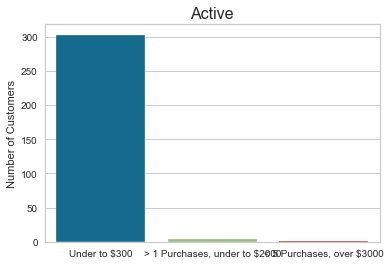

In [60]:
segment_active = data_segments[data_segments['RecencySegments'] == 'Active']

sns.set_style('whitegrid')
sns.countplot(x = 'FrequencyMonetarySegment', data = segment_active)

plt.title('Active', fontsize= 16)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.show()

## Warm Segment with K-Means Frequency/Amount segment

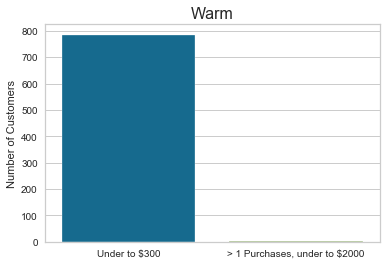

In [68]:
segment_warm = data_segments[data_segments['RecencySegments'] == 'Warm']

sns.set_style('whitegrid')
sns.countplot(x = 'FrequencyMonetarySegment', data = segment_warm)

plt.title('Warm', fontsize= 16)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.show()

## Cold Segment with K-Means Frequency/Amount segment

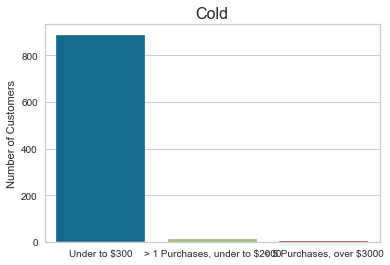

In [69]:
segment_cold = data_segments[data_segments['RecencySegments'] == 'Cold']

sns.set_style('whitegrid')
sns.countplot(x = 'FrequencyMonetarySegment', data = segment_cold)

plt.title('Cold', fontsize= 16)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.show()

## Inactive Segment with K-Means Frequency/Amount segment

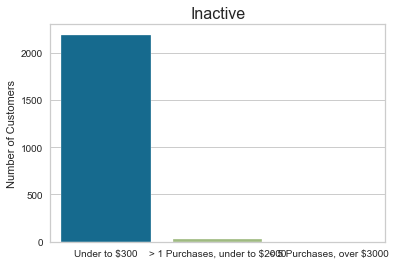

In [70]:
segment_inactive = data_segments[data_segments['RecencySegments'] == 'Inactive']

sns.set_style('whitegrid')
sns.countplot(x = 'FrequencyMonetarySegment', data = segment_inactive)

plt.title('Inactive', fontsize= 16)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.show()

Segmenting customers by recency, frequency, and monetary value gives the E-Commerce business a way to prioritize customer outreach (based on recency) and personalized promotions (based on the average amount spent and how often customers purchase).

Prioritize customer outreach based on Recency segments:
- Active
- Warm
- Cold
- Inactive

Each campaign should have promotions that are aligned with the spending amount of the group. How often you send the campaigns will depend on the group’s frequency.